In [1]:
import numpy as np
from itertools import product
import copy

In [7]:
'''
遗传算法，用于在第三问中每一次循环内求解，弃用
'''
# 效用函数示例，这里我们使用一个简单的逻辑函数作为示例
def utility_function(bitstring):
    # 这里是一个示例效用函数，实际应用中需要替换为具体问题的效用函数
    return np.sum(bitstring)

# 遗传算法参数
POPULATION_SIZE = 100  # 种群大小
GENES = 12  # 基因数量（即0,1串的长度）
MUTATION_RATE = 0.01  # 变异率
GENERATIONS = 500  # 迭代次数

# 初始化种群
def initialize_population(size, genes):
    return np.random.choice([0, 1], size=(size, genes))

# 评估种群
def evaluate_population(population, utility_func):
    return np.array([utility_func(individual) for individual in population])

# 选择（轮盘赌选择法）
def selection(population, fitness):
    fitness_sum = np.sum(fitness)
    probabilities = fitness / fitness_sum
    indices = np.random.choice(population.shape[0], size=population.shape[0], replace=True, p=probabilities)
    return population[indices]

# 交叉（单点交叉）
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, GENES)  # 随机选择交叉点
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

# 变异
def mutate(individual, mutation_rate):
    for i in range(GENES):
        if np.random.rand() < mutation_rate:
            individual[i] = 1 - individual[i]
    return individual

# 遗传算法主函数
def genetic_algorithm(utility_func):
    population = initialize_population(POPULATION_SIZE, GENES)
    best_solution = None
    best_fitness = -np.inf

    for generation in range(GENERATIONS):
        fitness = evaluate_population(population, utility_func)
        fitness =np.clip(fitness,a_min=1,a_max=None)
        best_idx = np.argmax(fitness)
        if fitness[best_idx] > best_fitness:
            best_fitness = fitness[best_idx]
            best_solution = population[best_idx].copy()

        selected = selection(population, fitness)
        next_generation = []
        for i in range(0, POPULATION_SIZE, 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, MUTATION_RATE)
            child2 = mutate(child2, MUTATION_RATE)
            next_generation.extend([child1, child2])
        population = np.array(next_generation)

    return best_solution, best_fitness

# 运行遗传算法
best_bitstring, best_fitness = genetic_algorithm(utility_function)
print("Best Bitstring:", best_bitstring)
print("Best Fitness:", best_fitness)

Best Bitstring: [1 1 1 1 1 1 1 1 1 1 1 1]
Best Fitness: 12


In [2]:
#流程图中的节点
class Node(object):
    def __init__(self,loss_rate,test_cost,attribute,number,is_tested) -> None:
        self.loss_rate = loss_rate#次品率，固有属性
        self.test_cost = test_cost#检测成本，固有属性
        self.attribute =attribute#三种类型之一
        self.number = number#个数
        self.is_tested =is_tested#是否被检查
#表示零件的节点
class Component(Node):
    def __init__(self, loss_rate, test_cost,buy_cost,number,is_tested) -> None:
        super().__init__(loss_rate, test_cost,"component",number,is_tested)
        self.buy_cost =buy_cost#购买单价
        self.real_loss_rate = loss_rate
#表示半成品的节点
class Semi_finished(Node):
    def __init__(self, loss_rate, test_cost,number,product_cost,destory_cost,is_tested) -> None:
        super().__init__(loss_rate, test_cost,"semi_finifshed", number,is_tested)
        self.product_cost =product_cost
        self.forward =np.array([])
        self.real_loss_rate =self.loss_rate #真实次品率，即考虑是否检查后生产的半成品的次品率
        self.destory_cost = destory_cost#拆解成本
    def add_component(self,com:Component):
        self.forward =np.append(self.forward,com)#添加生产半成品的零件类的信息，用于计算产量和次品率
    '''
    计算真实次品率
    '''
    def count_real_lossrate(self):
        if(len(self.forward)==2):
            x1 = self.forward[0].is_tested
            x2 =self.forward[1].is_tested
            n1 =self.forward[0].real_loss_rate
            n2 = self.forward[1].real_loss_rate
            n3 =self.loss_rate
            self.real_loss_rate =x1*x2*n3+(1-x1)*(1-x2)*(1-(1-n1)*(1-n2)*(1-n3))+x1*(1-x2)*(1-(1-n3)*(1-n2))+x2*(1-x1)*(1-(1-n3)*(1-n1))
        if(len(self.forward)==3):
            #对第三题有用，需要给出公式再完善
            x1 = self.forward[0].is_tested
            x2 =self.forward[1].is_tested
            x3 = self.forward[2].is_tested
            n1 = self.forward[0].real_loss_rate
            n2 = self.forward[1].real_loss_rate
            n3 = self.forward[2].real_loss_rate
            n4 = self.loss_rate
            self.real_loss_rate = 1-pow((1-n1),1-x1)*pow((1-n2),1-x2)*pow((1-n3),1-x3)*pow((1-n1),1-x1)*(1-n4)
    '''
    计算本轮的真实数量,并在number里面更新
    '''
    def count_real_number(self):
        num = np.array([])
        for i in self.forward:
            num = np.append(num,i.number*(1-i.is_tested*i.real_loss_rate))
        self.number =  num.min()
    '''
    计算正品数量
    '''
    def positive_object(self):
        self.positive = self.number*(1-self.real_loss_rate)
class Final_product(Node):
    def __init__(self, loss_rate, test_cost, number,product_cost,destory_cost,change_cost, price,is_tested) -> None:
        super().__init__(loss_rate, test_cost,"Final_product", number, is_tested)
        self.product_cost = product_cost
        self.forward = np.array([])
        self.real_loss_rate =self.loss_rate
        self.price =price#价格
        self.destory_cost =destory_cost#拆除成本
        self.change_cost = change_cost#更换成本呢
    def add_component(self,com):
        self.forward =np.append(self.forward,com)
    '''
    计算真实次品率
    '''
    def count_real_lossrate(self):
        if(len(self.forward)==2):
            x1 = self.forward[0].is_tested
            x2 =self.forward[1].is_tested
            n1 =self.forward[0].real_loss_rate
            n2 = self.forward[1].real_loss_rate
            n3 =self.loss_rate
            self.real_loss_rate =x1*x2*n3+(1-x1)*(1-x2)*(1-(1-n1)*(1-n2)*(1-n3))+x1*(1-x2)*(1-(1-n3)*(1-n2))+x2*(1-x1)*(1-(1-n3)*(1-n1))
            
        if(len(self.forward)==3):
            if(len(self.forward)==3):
            #对第三题有用，需要给出公式再完善
                x1 = self.forward[0].is_tested
                x2 =self.forward[1].is_tested
                x3 = self.forward[2].is_tested
                n1 = self.forward[0].real_loss_rate
                n2 = self.forward[1].real_loss_rate
                n3 = self.forward[2].real_loss_rate
                n4 = self.loss_rate
                self.real_loss_rate = 1-pow((1-n1),1-x1)*pow((1-n2),1-x2)*pow((1-n3),1-x3)*pow((1-n1),1-x1)*(1-n4)
    '''
    计算本轮的真实数量,并在number里面更新
    '''
    def count_real_number(self):
        num = np.array([])
        for i in self.forward:
            num =np.append(num,i.number*(1-i.is_tested*i.real_loss_rate))
        self.number =  num.min()  
    '''
    计算正品数量
    '''
    def positive_object(self):
        self.positive = self.number*(1-self.real_loss_rate)

In [3]:
'''
这个字典用于对题目二的不同检测方法进行索引，用于深度优先搜索
'''
test_dict  ={1:np.array([0,0,0]),2:np.array([0,0,1]),3:np.array([0,1,0]),4:np.array([1,0,0]),5:np.array([0,1,1]),6:np.array([1,0,1]),7:np.array([1,1,0]),8:np.array([1,1,1])}
'''
用于解决第二问的深度优先搜索树的节点结构，记录了历史检测方法的操作索引，本轮检测方法的索引，当前层次，当前的累计盈利，上一层到这一层的转化成本
'''
class DFS_NODE(object):
    def __init__(self,history_test:np.array,now_test:int,now_level:int,now_benefit:float,change_cost:float) -> None:
        self.history_test =history_test
        self.now_test =now_test
        self.now_level =now_level
        self.now_benefit =now_benefit
        self.change_cost = change_cost

In [4]:
class Produce_loop(object):
    '''
    level_count:工艺层数
    final:成品节点
    node_list:半成品节点
    '''
    def __init__(self,level_count:int,final:Final_product,node_list:np.array) -> None:
        self.level_count = level_count
        self.final = final
        self.node_list = node_list
        self.origin_num = []#初始的零件数量
        self.Total_benefit =0#累计利润
        self.buy_cost =0#购买成本
        self.X = np.array([])#最优选择
        self.destory_choice =np.array([])#拆解内容的选择
        self.component_num =0#零件数量
        self.benefit_each_batch =np.array([])#每一轮的利润
        if(self.level_count==3):
            for i in self.node_list:
                for j in i.forward:
                    self.component_num+=1
                    self.buy_cost+=j.number*j.buy_cost
                    self.origin_num.append(j.number)
        else:
            for i in self.final.forward:
                self.component_num+=1
                self.buy_cost+=i.number*i.buy_cost
                self.origin_num.append(i.number)        
    '''
    向前计算每一层的数量，真实次品率和正品个数(需要先规定is_tested，即确定策略)
    '''
    def cal_forward(self):
        if(self.level_count==3):
            for i in self.node_list:
                i.count_real_lossrate()
                i.count_real_number()
                i.positive_object()
        self.final.count_real_lossrate()
        self.final.count_real_number()
        self.final.positive_object()
    '''
    向后计算，用于调整零件的数量和次品率开启新的循环：输入:X本轮对于每一个可拆解的组件(半成品/成品)是否拆解的选择
    '''
    def backward(self,X:np.array):
        #先看成品是否拆解
        all_product =[]#记录零件下一轮的总数
        for i in range(self.component_num):
            if(X[-1]==1):#拆解成品
                all_product.append(self.final.number-self.final.positive)#所有的次都被拆成了零件
            else:
                all_product.append(0)
        if(self.level_count==3):#存在半成品的情况
            tag =0
            for i in range(len(self.node_list)):
                if(X[i]==1):#需要拆解
                    for j in self.node_list[i].forward:
                        #累加零件的数量
                        all_product[tag]+= self.node_list[i].number-self.node_list[i].positive
                        if(j.is_tested==1):#如果零件被检测则没有次品
                            j.real_loss_rate= 0
                            j.number = all_product[tag]
                        else: #如果没有被检验则则次品是过程开使时的次品数
                            j.real_loss_rate = j.number*j.real_loss_rate/all_product[tag]
                            j.number = all_product[tag]
                        tag+=1
                else:#不需要拆解则不需要增加
                    for j in self.node_list[i].forward:
                        if(j.is_tested==1):#如果零件被检测则没有次品
                            j.real_loss_rate= 0
                            j.number = all_product[tag]
                        else: #如果没有被检验则则次品是过程开使时的次品数
                            try:
                                j.real_loss_rate = j.number*j.real_loss_rate/all_product[tag]
                            except:
                                j.real_loss =0#证明没有新的零件进入循环
                            j.number = all_product[tag]
                        tag+=1
        else:#不存在半成品的情况
            tag =0
            for i in self.final.forward:
                if(i.is_tested==1):
                    i.real_loss_rate =0
                    i.number = all_product[tag]
                else:
                    i.real_loss_rate = i.number*i.real_loss_rate/all_product[tag]
                    i.number =all_product[tag]
                tag+=1
    '''
    修改是否检测零件，半成品，成品的策略(为了方便，这里面的x是从成品到半成品到零件的顺序)
    '''
    def change_choice(self,X:np.array):
        self.final.is_tested = X[0]
        if(self.level_count==2):
            tag =1
            for i in self.final.forward:
                i.is_tested = X[tag]
                tag+=1
        else:
            tag =1
            for i in self.final.forward:
                i.is_tested =X[tag]
                tag+=1
            for i in self.final.forward:
                for j in i.forward:
                    j.is_tested =X[tag]
                    tag+=1
    '''
    得到一轮中的盈利
    '''
    def benefit_one_batch(self):
        if(self.final.number<=1):return-1
        return self.final.positive*self.final.price
    '''
    得到一轮中的成本
    '''
    def cost_one_batch(self):
        if(self.final.number<=1): return -1
        cost =0
        cost+=self.final.number*(self.final.is_tested*self.final.test_cost+self.final.product_cost)+(1-self.final.is_tested)*self.final.number*self.final.change_cost*self.final.real_loss_rate#产品检测成本和生产成本,调换成本
        if(self.level_count==3):
            for i in self.node_list:
                cost+=i.number*(i.is_tested*i.test_cost+i.product_cost)
                for j in i.forward:
                    cost+=j.number*j.is_tested*j.test_cost
        else:
            for i in self.final.forward:
                cost+=i.is_tested*i.number*i.test_cost
        return cost
    '''
    得到拆解成本,X为记录成品/半成品是否拆解的变量,从半成品到成品记录
    '''
    def destory_cost(self,X:np.array):
        cost =0
        if(X[-1]==1):#需要拆解成品
            cost+=(self.final.number-self.final.positive)*self.final.destory_cost
        if(self.level_count==3):
            tag =0
            for i in self.node_list:
                cost+=X[tag]*(i.number-i.positive)*i.destory_cost
                tag+=1
        return cost
    #选择最优的策略
    def optimizer(self):
        if(self.level_count==2): choose_number =3
        else: choose_number =12
        max_benefit =0
        X_max =np.full(choose_number,-1)
        if(choose_number==3):#遍历的方法，第二问只有三层循环
            for a1,a2,a3 in product(range(2), repeat=3):
                X =np.array([a1,a2,a3])
                self.change_choice(X)#改变策略
                self.cal_forward()#更新参数
                benefit = self.benefit_one_batch()-self.cost_one_batch()#计算成本
                if(benefit>max_benefit): 
                    X_max =X.copy()
                    max_benefit =benefit
        if(choose_number==12):
            '''
            遗传算法 
            '''
            #def benefit_for_genetic(X:np.array):
                #self.change_choice(X)
                #self.cal_forward()
                #return self.benefit_one_batch()-self.cost_one_batch()
            #X_max,max_benefit = genetic_algorithm(benefit_for_genetic)
            '''
            暴力遍历
            '''
            for a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12 in product(range(2), repeat=12):
                X =np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12])
                self.change_choice(X)#改变策略
                self.cal_forward()#更新参数
                benefit = self.benefit_one_batch()-self.cost_one_batch()#计算成本
                if(benefit>max_benefit): 
                    X_max =X.copy()
                    max_benefit =benefit
        return (X_max,max_benefit)
    '''
    根据历史路径去恢复当前系统状态（结合DFS使用）
    '''
    def recover(self,history:np.array):
        #首先对零件参数进行恢复（先只写题目二的）
        if(self.level_count==2):
            tag =0
            for i in self.final.forward:
                i.number = self.origin_num[tag]#恢复数量
                i.real_loss_rate =i.loss_rate#恢复真实次品率
                tag+=1
            for i in history:#然后对每一层进行推理
                self.change_choice(test_dict[i])
                self.cal_forward()
                self.backward(np.array([1]))
    '''
    利用深度优先搜索求问题二的全局最优解,规定深度
    '''
    def DFS(self,deep:int):
        #初始化节点栈,并加入第一层操作
        q = []
        for index in test_dict.keys():
            q.append(DFS_NODE(np.array([]),index,1,0,0))
        MAX_BENEFIT =0#记录最大利润
        MAX_BENEFIT_NODE=None#记录最大利润对应的操作序列
        while(len(q)!=0):
            now_node = q.pop()#得到当前节点
            #重新更新流程网络的状态并计算当前选择的利润
            if(now_node.now_level>deep):#如果当前层次大于设定的最深层次则不再更新,只判断是否更新MAX_BENEFIT
                if(now_node.now_benefit>MAX_BENEFIT):#如果大于增更新策略
                    MAX_BENEFIT = now_node.now_benefit
                    MAX_BENEFIT_NODE = now_node.history_test
                continue
            self.recover(now_node.history_test)#恢复系统状态
            self.change_choice(test_dict[now_node.now_test])#按照本轮选择更新
            self.cal_forward()#更新参数
            benefit =self.benefit_one_batch()-self.cost_one_batch()#计算成本
            if(benefit-now_node.change_cost<=0):#如果本轮成本为负责检查进行本轮前的利润是否大于最大值
                if(now_node.now_benefit>MAX_BENEFIT):#如果大于增更新策略
                    MAX_BENEFIT = now_node.now_benefit
                    MAX_BENEFIT_NODE = now_node.history_test
            else:#如果本轮仍能盈利则计算转化成本并且将下一层的节点添加到栈中
                ds = self.destory_cost(np.array([1]))#计算进入下一轮需要的拆解成本
                #将下一轮的所有节点添加进栈中
                for index in test_dict.keys():
                    q.append(DFS_NODE(np.append(now_node.history_test,now_node.now_test),index,now_node.now_level+1,now_node.now_benefit+benefit-now_node.change_cost,ds))
        return MAX_BENEFIT,MAX_BENEFIT_NODE
    '''
    主循环得到整体的策略
    '''
    def max_loop(self):
        CHANGE_COST =0#拆解成本
        if(self.level_count==2):#题目二情况
            while(1):
                X,benefit = self.optimizer()
                if(X[0]==-1): break
                if(benefit-CHANGE_COST<=0): break
                self.X = np.append(self.X,X)#记录这种状态
                self.destory_choice = np.append(self.destory_choice,np.array([1]))
                self.Total_benefit+=benefit-CHANGE_COST#增加利润
                self.change_choice(X)#按照最大的情况并更新参数
                self.cal_forward()
                CHANGE_COST =self.destory_cost(np.array([1]))#计算这种情况下的拆解成本
                self.backward(np.array([1]))#更新拆解后的情况
        else:#题目三情况
            #第一轮循环单独进行
            X,benefit = self.optimizer()
            self.X = np.append(self.X,X)#记录这种状态
            #self.destory_choice = np.append(self.destory_choice,DESTORY)
            self.Total_benefit+=benefit-CHANGE_COST#增加利润
            self.benefit_each_batch = np.append(self.benefit_each_batch,benefit-CHANGE_COST)
            self.change_choice(X)#按照最大的情况并更新参数
            self.cal_forward()
            while(1):
                MAXBENEFIT =np.full(16,-1)
                MAX_X =np.full(16,None)
                destory_case =np.full(16,None)
                i =0
                for a1,a2,a3,a4 in product(range(2), repeat=4):#生成拆解的选择并进行计算
                    if((a1+a2+a3+a4==0)or(((a1+a2+a3)<3)and (a4==0))):continue#都不拆解或者在成品不拆解的情况下半成品只拆解一部分
                    destory = np.array([a1,a2,a3,a4])
                    new_case = copy.deepcopy(self)#得到此类的深拷贝后的副本
                    CHANGE_COST =new_case.destory_cost(destory)#计算这种情况的成本
                    new_case.backward(destory)#更新拆解后的情况
                    X,benefit = new_case.optimizer()
                    if(X[0]==-1): continue
                    if(benefit-CHANGE_COST<=0): continue
                    MAXBENEFIT[i] = benefit-CHANGE_COST
                    MAX_X[i]= X
                    destory_case[i] =destory#记录情况
                    i+=1
                    print("one_case_calculated\n")
                #选择最大利润对应的操作并且更新类的状态
                max_index = np.argmax(MAXBENEFIT,axis=0)#最大值对应的索引
                if MAXBENEFIT[max_index]==-1: break#无法继续盈利，退出
                else:
                    self.X =np.append(self.X,MAX_X[max_index])#记录状态
                    self.destory_choice = np.append(self.destory_choice,destory_case[max_index])
                    self.Total_benefit+=MAXBENEFIT[max_index]
                    self.benefit_each_batch = np.append(self.benefit_each_batch,MAXBENEFIT[max_index])
                    #将对象的状态更新：
                    self.backward(destory_case[max_index])
                    self.change_choice(MAX_X[max_index])
                    self.cal_forward()
                print("******one_batch_finish****\n")

In [54]:
Q1 = 0.1
Q2 =0.2
Q3 =0.1
u = 1.64
n =1000
def new_q(q):
    return q+u*pow(q*(1-q)/(n-1),0.5)
c1 =Component(Q1,8,4,10000,0)
c2 =Component(Q2,1,18,10000,0)
f1= Final_product(Q3,3,0,6,5,10,56,0)
f1.add_component(c1)
f1.add_component(c2)
p = Produce_loop(2,f1,None)
max_benefit,choose = p.DFS(5)
#p.max_loop()
#p.X,p.Total_benefit/p.buy_cost
max_benefit/p.buy_cost,choose

(1.138641723076923, array([4., 5., 1., 1., 1.]))

In [39]:
LOSS_RATE =new_q(0.1)
NUM =100000
IS_TESTED =0
c2_1 = Component(LOSS_RATE,1,2,NUM,IS_TESTED)
c2_2 =Component(LOSS_RATE,1,8,NUM,IS_TESTED)
c2_3 = Component(LOSS_RATE,2,12,NUM,IS_TESTED)
c2_4 = Component(LOSS_RATE,1,2,NUM,IS_TESTED)
c2_5 = Component(LOSS_RATE,1,8,NUM,IS_TESTED)
c2_6 = Component(LOSS_RATE,2,12,NUM,IS_TESTED)
c2_7 = Component(LOSS_RATE,1,8,NUM,IS_TESTED)
c2_8 = Component(LOSS_RATE,2,12,NUM,IS_TESTED)
s2_1 = Semi_finished(LOSS_RATE,4,8,8,6,IS_TESTED)
s2_2 = Semi_finished(LOSS_RATE,4,8,8,6,IS_TESTED)
s2_3 = Semi_finished(LOSS_RATE,4,8,8,6,IS_TESTED)
s2_1.add_component(c2_1)
s2_1.add_component(c2_2)
s2_1.add_component(c2_3)
s2_2.add_component(c2_4)
s2_2.add_component(c2_5)
s2_2.add_component(c2_6)
s2_3.add_component(c2_7)
s2_3.add_component(c2_8)
f2_1= Final_product(LOSS_RATE,6,NUM,8,10,40,200,IS_TESTED)
f2_1.add_component(s2_2)
f2_1.add_component(s2_1)
f2_1.add_component(s2_3)
p =Produce_loop(3,f2_1,np.array([s2_1,s2_2,s2_3]))
p.max_loop()
p.X,p.destory_choice,p.Total_benefit/p.buy_cost,p.benefit_each_batch

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

******one_batch_finish****

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

******one_batch_finish****

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

******one_batch_finish****

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

******one_batch_finish****

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_case_calculated

one_ca

(array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 1.703935276284632,
 array([8.56515777e+06, 1.83046900e+06, 3.98633000e+05, 8.68130000e+04,
        1.89050000e+04, 4.11700000e+03, 8.96000000e+02, 1.95000000e+02]))

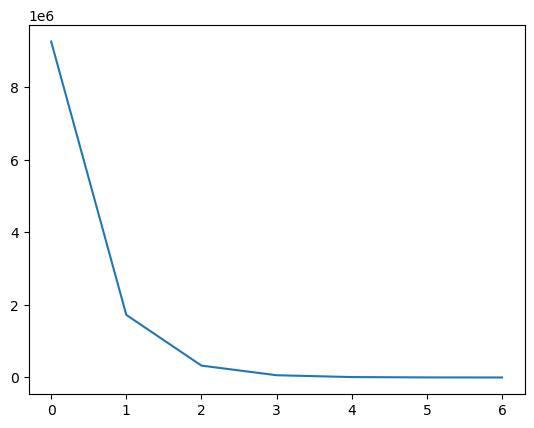

In [51]:
from matplotlib import pyplot as plt 
plt.plot(p.benefit_each_batch)
plt.show()